<a id="1"></a>
# **<center><span style="color:#005dc4;">1. Import Libraries</span></center>**

In [1]:
import numpy as np
import pandas as pd
import os
import cv2
import matplotlib.pyplot as plt
import seaborn as sns
import tensorflow as tf
import keras 
from tqdm import tqdm
from keras.callbacks import EarlyStopping,ModelCheckpoint
from sklearn.metrics import confusion_matrix , accuracy_score
from sklearn.metrics import classification_report
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
import glob 
import pandas as pan
import matplotlib.pyplot as plotter
import warnings
warnings.filterwarnings('ignore')

<a id="2"></a>
# **<center><span style="color:#005dc4;">2. Read Dataset</span></center>**

In [2]:
image_data= 'garbage_dataset'
pd.DataFrame(os.listdir(image_data),columns=['Files_Name'])

,Files_Name
0,battery
1,biological
2,brown-glass
3,cardboard
4,clothes
5,green-glass
6,metal
7,paper
8,plastic
9,shoes


In [3]:
files = [i for i in glob.glob(image_data + "//*//*")]
np.random.shuffle(files)
labels = [os.path.dirname(i).split("/")[-1] for i in files]
data = zip(files, labels)
dataframe = pan.DataFrame(data, columns = ["Image", "Label"])
dataframe

,Image,Label
0,garbage_dataset\clothes\clothes2372.jpg,garbage_dataset\clothes
1,garbage_dataset\clothes\clothes4170.jpg,garbage_dataset\clothes
2,garbage_dataset\trash\trash257.jpg,garbage_dataset\trash
3,garbage_dataset\brown-glass\brown-glass221.jpg,garbage_dataset\brown-glass
4,garbage_dataset\clothes\clothes4327.jpg,garbage_dataset\clothes
...,...,...
15510,garbage_dataset\plastic\plastic148.jpg,garbage_dataset\plastic
15511,garbage_dataset\clothes\clothes2518.jpg,garbage_dataset\clothes
15512,garbage_dataset\plastic\plastic13.jpg,garbage_dataset\plastic
15513,garbage_dataset\paper\paper977.jpg,garbage_dataset\paper


<a id="3"></a>
# **<center><span style="color:#005dc4;">3. Visualization</span></center>**

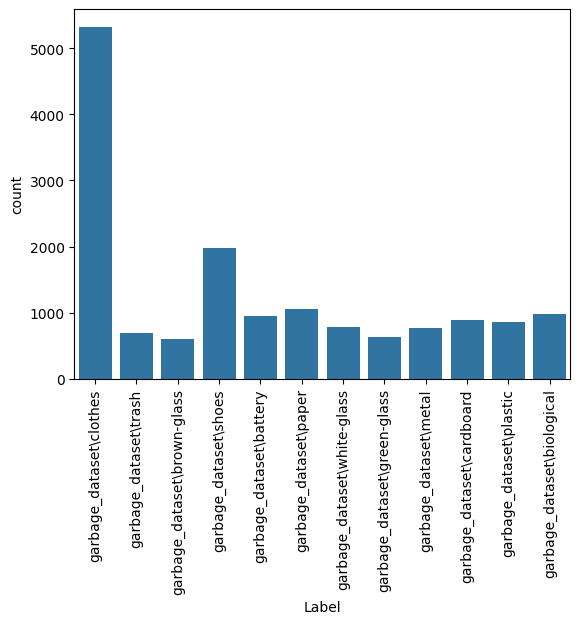

In [4]:
sns.countplot(x = dataframe["Label"])
plotter.xticks(rotation = 90);

<a id="4"></a>
# **<center><span style="color:#005dc4;">4. Split Dataset</span></center>**

In [5]:
train_data_dir =image_data
batch_size = 264                           
target_size = (300,300)
validation_split = 0.2

In [6]:

train= tf.keras.preprocessing.image_dataset_from_directory(
    train_data_dir,
    validation_split=validation_split,
    subset="training",
    seed=50,                                                         
    image_size=target_size,
    batch_size=batch_size,
)
validation= tf.keras.preprocessing.image_dataset_from_directory(
    train_data_dir,
    validation_split=validation_split,
    subset="validation",
    seed=100,                                                         
    image_size=target_size,
    batch_size=batch_size,
)

Found 15524 files belonging to 12 classes.
Using 12420 files for training.
Found 15524 files belonging to 12 classes.
Using 3104 files for validation.


In [7]:
class_names = train.class_names
class_names

['battery',
 'biological',
 'brown-glass',
 'cardboard',
 'clothes',
 'green-glass',
 'metal',
 'paper',
 'plastic',
 'shoes',
 'trash',
 'white-glass']

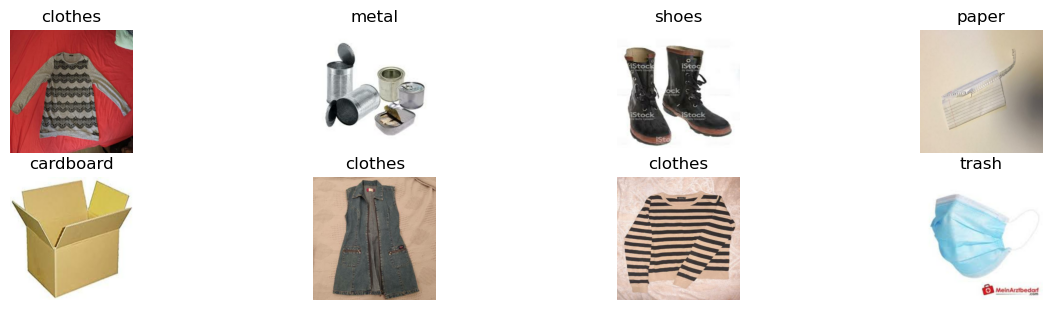

In [8]:
plt.figure(figsize=(15, 15))
for images, labels in train.take(1):
    for i in range(8):
        ax = plt.subplot(8, 4, i + 1)
        plt.imshow(images[i].numpy().astype("uint8"))
        plt.title(class_names[labels[i]])
        plt.axis("off")

<a id="5"></a>
# **<center><span style="color:#005dc4;">5. Build Deep Learning Model</span></center>**

In [7]:
im_shape = (300,300)
batch_size = 128
seed = 42

In [8]:
base_model = tf.keras.applications.EfficientNetV2B1(weights='imagenet', include_top=False, input_shape=(im_shape[0], im_shape[1], 3))

x = base_model.output
x = keras.layers.Flatten()(x)
x = keras.layers.Dense(100, activation='relu')(x)
predictions = keras.layers.Dense(12, activation='softmax', kernel_initializer='random_uniform')(x)

model = keras.models.Model(inputs=base_model.input, outputs=predictions)

# Freezing pretrained layers
for layer in base_model.layers:
    layer.trainable=False

# model.summary()
model.compile(optimizer='Adam',loss='categorical_crossentropy',metrics=['accuracy'])

In [9]:
model.summary()

Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer         │ (None, 300, 300,  │          0 │ -                 │
│ (InputLayer)        │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ rescaling           │ (None, 300, 300,  │          0 │ input_layer[0][0] │
│ (Rescaling)         │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ normalization       │ (None, 300, 300,  │          0 │ rescaling[0][0]   │
│ (Normalization)     │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ stem_conv (Conv2D)  │ (None, 150, 150,  │        864 │ normalization[0]… │
│                     │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ stem_bn             │ (None, 150, 150,  │        128 │ stem_conv[0][0]   │
│ (BatchNormalizatio… │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ stem_activation     │ (None, 150, 150,  │          0 │ stem_bn[0][0]     │
│ (Activation)        │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block1a_project_co… │ (None, 150, 150,  │      4,608 │ stem_activation[… │
│ (Conv2D)            │ 16)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block1a_project_bn  │ (None, 150, 150,  │         64 │ block1a_project_… │
│ (BatchNormalizatio… │ 16)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block1a_project_ac… │ (None, 150, 150,  │          0 │ block1a_project_… │
│ (Activation)        │ 16)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block1b_project_co… │ (None, 150, 150,  │      2,304 │ block1a_project_… │
│ (Conv2D)            │ 16)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block1b_project_bn  │ (None, 150, 150,  │         64 │ block1b_project_… │
│ (BatchNormalizatio… │ 16)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block1b_project_ac… │ (None, 150, 150,  │          0 │ block1b_project_… │
│ (Activation)        │ 16)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block1b_drop        │ (None, 150, 150,  │          0 │ block1b_project_… │
│ (Dropout)           │ 16)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block1b_add (Add)   │ (None, 150, 150,  │          0 │ block1b_drop[0][… │
│                     │ 16)               │            │ block1a_project_… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block2a_expand_conv │ (None, 75, 75,    │      9,216 │ block1b_add[0][0] │
│ (Conv2D)            │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block2a_expand_bn   │ (None, 75, 75,    │        256 │ block2a_expand_c… │
│ (BatchNormalizatio… │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block2a_expand_act… │ (None, 75, 75,    │          0 │ block2a_expand_b

 Total params: 19,732,436 (75.27 MB)

 Trainable params: 12,801,312 (48.83 MB)

 Non-trainable params: 6,931,124 (26.44 MB)

In [10]:
checkpoint =ModelCheckpoint("models/garbage_classifier.keras", save_best_only=True)

In [11]:
early_stopping =EarlyStopping(patience=10, restore_best_weights=True)    

In [12]:
model.compile(optimizer ='Adam',loss='sparse_categorical_crossentropy', metrics=['accuracy'])

In [13]:
hist= model.fit(train,epochs=10,validation_data=validation,callbacks=[checkpoint,early_stopping])

Epoch 1/10
48/48 ━━━━━━━━━━━━━━━━━━━━ 662s 13s/step - accuracy: 0.7552 - loss: 0.8535 - val_accuracy: 0.9771 - val_loss: 0.0800
Epoch 2/10
48/48 ━━━━━━━━━━━━━━━━━━━━ 656s 14s/step - accuracy: 0.9717 - loss: 0.0918 - val_accuracy: 0.9861 - val_loss: 0.0473
Epoch 3/10
48/48 ━━━━━━━━━━━━━━━━━━━━ 733s 15s/step - accuracy: 0.9927 - loss: 0.0226 - val_accuracy: 0.9897 - val_loss: 0.0398
Epoch 4/10
48/48 ━━━━━━━━━━━━━━━━━━━━ 743s 16s/step - accuracy: 0.9899 - loss: 0.0390 - val_accuracy: 0.9907 - val_loss: 0.0340
Epoch 5/10
48/48 ━━━━━━━━━━━━━━━━━━━━ 734s 15s/step - accuracy: 0.9953 - loss: 0.0176 - val_accuracy: 0.9897 - val_loss: 0.0377
Epoch 6/10
48/48 ━━━━━━━━━━━━━━━━━━━━ 688s 14s/step - accuracy: 0.9977 - loss: 0.0106 - val_accuracy: 0.9913 - val_loss: 0.0394
Epoch 7/10
48/48 ━━━━━━━━━━━━━━━━━━━━ 706s 15s/step - accuracy: 0.9984 - loss: 0.0073 - val_accuracy: 0.9897 - val_loss: 0.0469
Epoch 8/10
48/48 ━━━━━━━━━━━━━━━━━━━━ 626s 13s/step - accuracy: 0.9976 - loss: 0.0064 - val_accuracy: 0.

In [14]:
score, acc = model.evaluate(validation)
print('Test Loss =', score)
print('Test Accuracy =', acc)

12/12 ━━━━━━━━━━━━━━━━━━━━ 122s 10s/step - accuracy: 0.9918 - loss: 0.0301
Test Loss = 0.033981189131736755
Test Accuracy = 0.9906572103500366


In [15]:
hist_=pd.DataFrame(hist.history)
hist_

,accuracy,loss,val_accuracy,val_loss
0,0.877617,0.429271,0.977126,0.079966
1,0.977053,0.073670,0.986147,0.047284
2,0.993720,0.020971,0.989691,0.039776
3,0.991707,0.031880,0.990657,0.033981
4,0.994605,0.017886,0.989691,0.037734
5,0.997504,0.010350,0.991302,0.039354
6,0.998229,0.008496,0.989691,0.046911
7,0.997826,0.006526,0.990657,0.046516
8,0.998229,0.005863,0.989691,0.049740
9,0.998792,0.004905,0.991624,0.041243


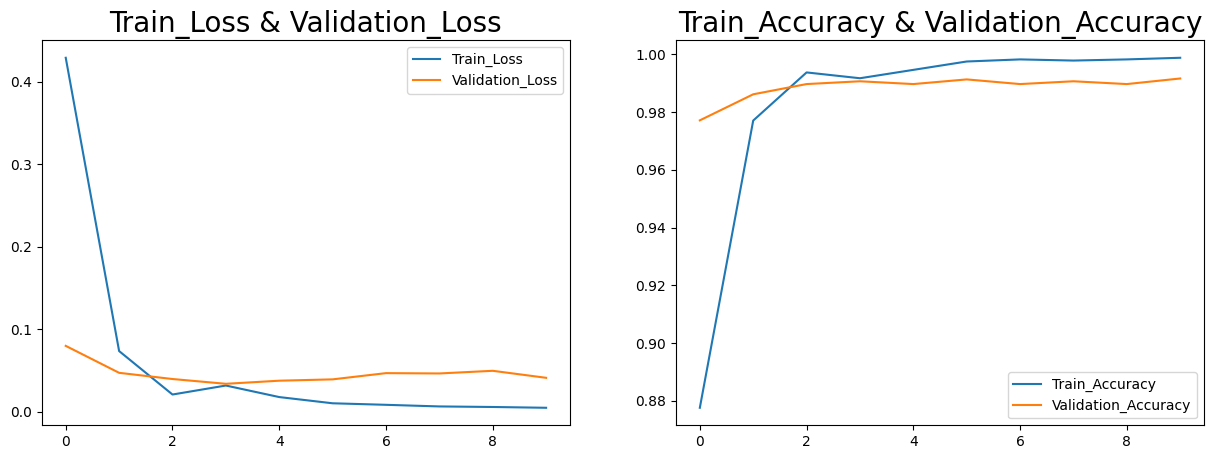

In [16]:
plt.figure(figsize=(15,5))
plt.subplot(1,2,1)
plt.plot(hist_['loss'],label='Train_Loss')
plt.plot(hist_['val_loss'],label='Validation_Loss')
plt.title('Train_Loss & Validation_Loss',fontsize=20)
plt.legend()
plt.subplot(1,2,2)
plt.plot(hist_['accuracy'],label='Train_Accuracy')
plt.plot(hist_['val_accuracy'],label='Validation_Accuracy')
plt.title('Train_Accuracy & Validation_Accuracy',fontsize=20)
plt.legend()

In [17]:
X_val,y_val,y_pred=[],[],[]
for images, labels in validation:
    y_val.extend(labels.numpy())
    X_val.extend(images.numpy())
predictions=model.predict(np.array(X_val))
for i in predictions:
    y_pred.append(np.argmax(i))
df=pd.DataFrame()
df['Actual'],df['Prediction']=y_val,y_pred
df

97/97 ━━━━━━━━━━━━━━━━━━━━ 145s 1s/step


,Actual,Prediction
0,8,8
1,9,9
2,9,9
3,4,4
4,0,0
...,...,...
3099,4,4
3100,11,11
3101,4,4
3102,4,4


In [20]:
class_names = train.class_names
class_names

['battery',
 'biological',
 'brown-glass',
 'cardboard',
 'clothes',
 'green-glass',
 'metal',
 'paper',
 'plastic',
 'shoes',
 'trash',
 'white-glass']

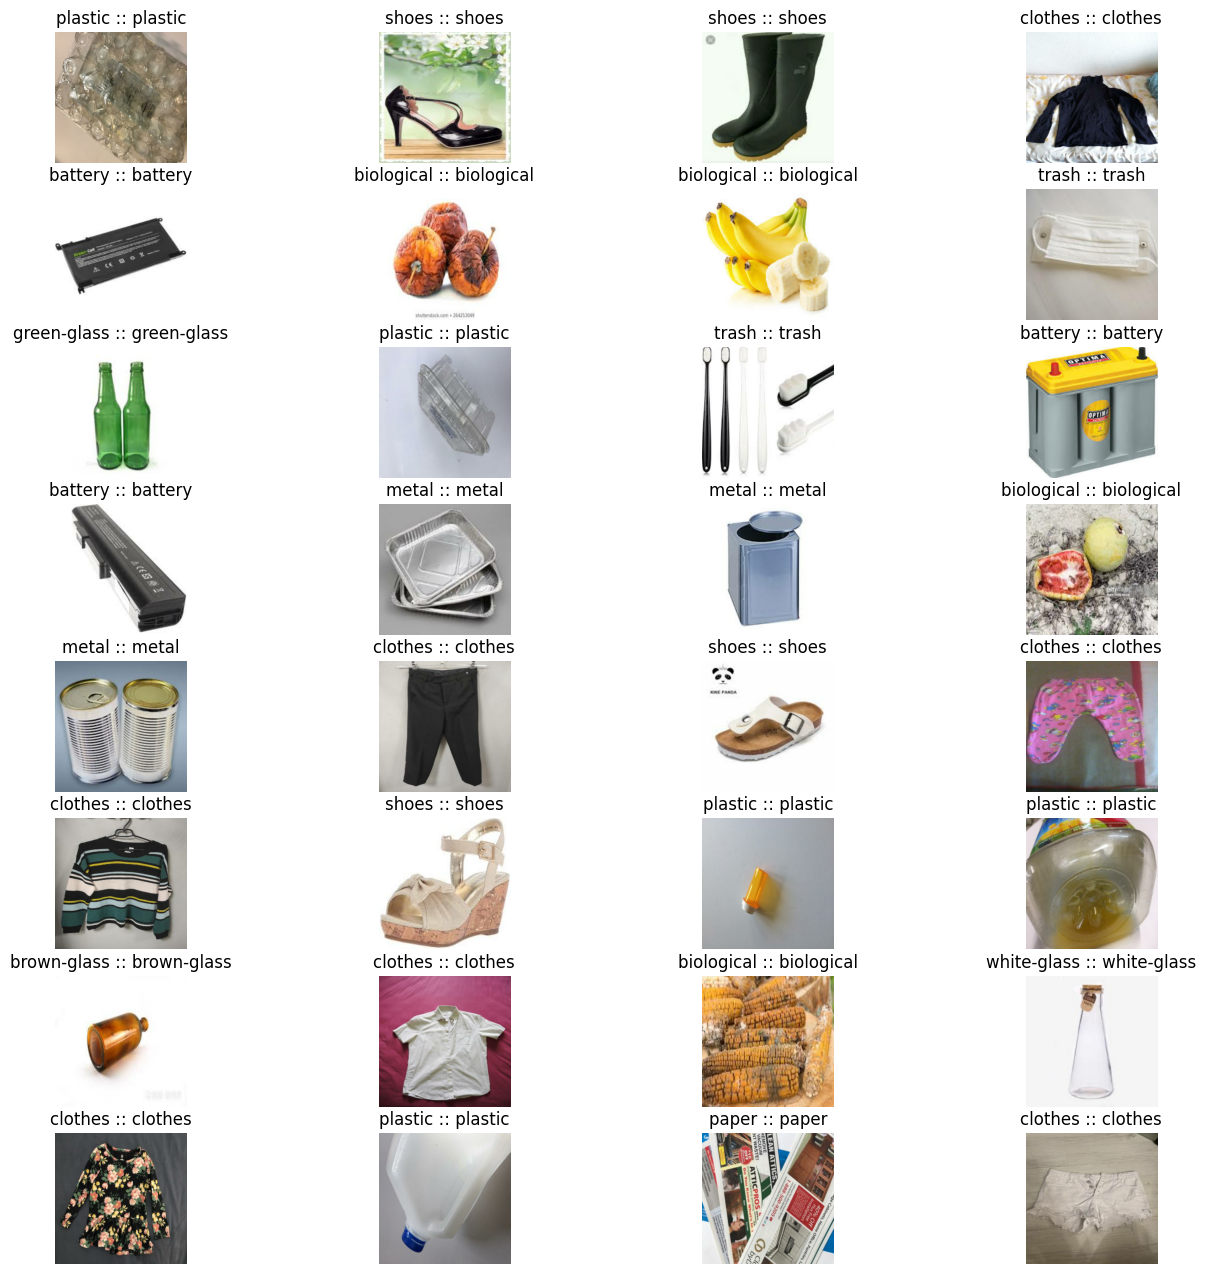

In [21]:
plt.figure(figsize=(16,16))
for i in range(32):
    ax = plt.subplot(8, 4, i + 1)
    plt.imshow(X_val[i].astype("uint8"))
    plt.title(f'{class_names[y_val[i]]} :: {class_names[y_pred[i]]}')
    plt.axis("off")

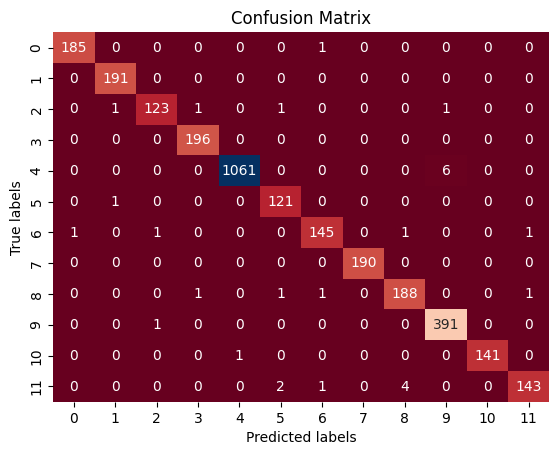

array([[ 185,    0,    0,    0,    0,    0,    1,    0,    0,    0,    0,
           0],
       [   0,  191,    0,    0,    0,    0,    0,    0,    0,    0,    0,
           0],
       [   0,    1,  123,    1,    0,    1,    0,    0,    0,    1,    0,
           0],
       [   0,    0,    0,  196,    0,    0,    0,    0,    0,    0,    0,
           0],
       [   0,    0,    0,    0, 1061,    0,    0,    0,    0,    6,    0,
           0],
       [   0,    1,    0,    0,    0,  121,    0,    0,    0,    0,    0,
           0],
       [   1,    0,    1,    0,    0,    0,  145,    0,    1,    0,    0,
           1],
       [   0,    0,    0,    0,    0,    0,    0,  190,    0,    0,    0,
           0],
       [   0,    0,    0,    1,    0,    1,    1,    0,  188,    0,    0,
           1],
       [   0,    0,    1,    0,    0,    0,    0,    0,    0,  391,    0,
           0],
       [   0,    0,    0,    0,    1,    0,    0,    0,    0,    0,  141,
           0],
       [   0,    0,  

In [22]:
ax= plt.subplot()
CM = confusion_matrix(y_val,y_pred)
sns.heatmap(CM, annot=True, fmt='g', ax=ax,cbar=False,cmap='RdBu')
ax.set_xlabel('Predicted labels')
ax.set_ylabel('True labels') 
ax.set_title('Confusion Matrix')
plt.show()
CM

<a id="7"></a>
# **<center><span style="color:#005dc4;">6. Accuracy</span></center>**

In [23]:
Acc = accuracy_score(y_val,y_pred)
print("accuracy is: {0:.4f}%".format(Acc * 100))

accuracy is: 99.0657%


<a id="7"></a>
# **<center><span style="color:#005dc4;">7. Save Model</span></center>**

In [25]:
keras.saving.save_model(model, 'models/garbage_classifier.h5')